In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import itertools

# Data Importing

In [22]:
df = pd.read_csv('../data/prices_greed_score_clean.csv')

In [117]:
df

,date,price,Fear&Greed
0,2018-02-01,9052.5763,30
1,2018-02-02,8827.6300,15
2,2018-02-03,9224.3913,40
3,2018-02-04,8186.6488,24
4,2018-02-05,6914.2600,11
...,...,...,...
1117,2021-02-25,47104.7833,79
1118,2021-02-26,46329.7400,55
1119,2021-02-27,46189.3783,56
1120,2021-02-28,45256.4133,55


# ARIMA exploration

In [43]:
y = df['price']
y.shape

(2862,)

In [42]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(y)[1])

p-value:  2.5264145709226113e-08


In [45]:
# First diff
print('p-value: ', adfuller(y.diff(1).fillna(0))[1])

p-value:  2.0357146227314016e-23


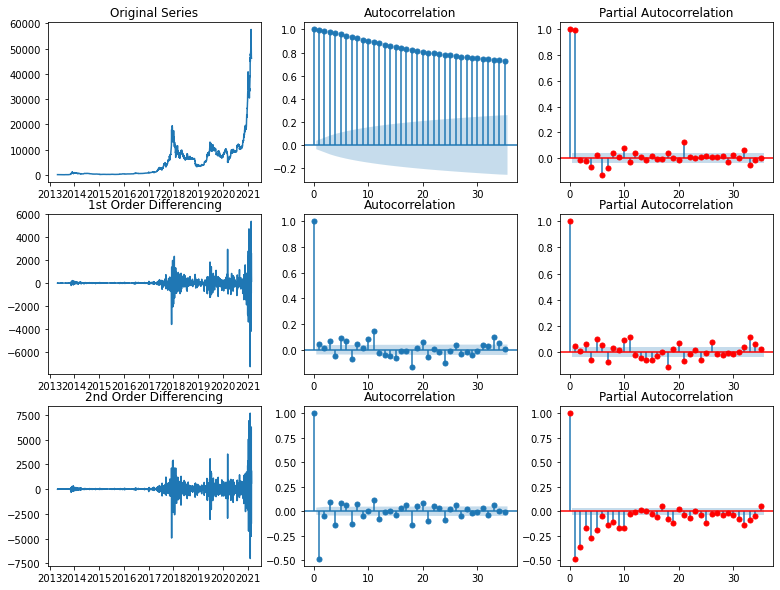

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 3, figsize=(13,10))
axes[0, 0].plot(y); axes[0, 0].set_title('Original Series')
plot_acf(y, ax=axes[0, 1])
plot_pacf(y, ax=axes[0, 2],c='r')

# 1st Differencing
axes[1, 0].plot(y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y.diff().dropna(), ax=axes[1, 1])
plot_pacf(y.diff().dropna(), ax=axes[1, 2],c='r')

# 2nd Differencing
axes[2, 0].plot(y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(y.diff().diff().dropna(), ax=axes[2, 2],c='r')

plt.show()

In [56]:
from statsmodels.tsa.arima_model import ARIMA

# 1. initialize the model
arima = ARIMA(y, order=(1, 1, 1))

# 2. fit the models
arima = arima.fit()

arima.summary()

/home/diego/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
/home/diego/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/diego/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
/home/diego/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2861
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -21260.233
Method:                       css-mle   S.D. of innovations            408.343
Date:                Wed, 03 Mar 2021   AIC                          42528.465
Time:                        13:09:58   BIC                          42552.301
Sample:                             1   HQIC                         42537.060
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -15.7360      9.707     -1.621      0.105     -34.761       3.289
ar.L1.D.Close     0.8569      0.049     17.530      0.000       0.761       0.953
ma.L1.D.Close    -0.8180      0.054    -15.165      0.000      -0.924      -0.712
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1669           +0.0000j            1.1669            0.0000
MA.1            1.2225           +0.0000j            1.2225            0.0000
-----------------------------------------------------------------------------
"""

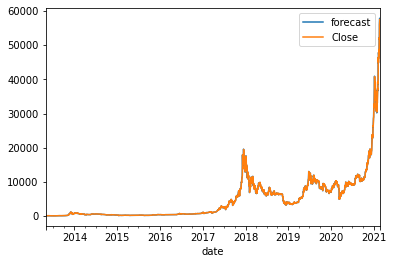

In [57]:
# Actual vs Fitted
arima.plot_predict(dynamic=False);

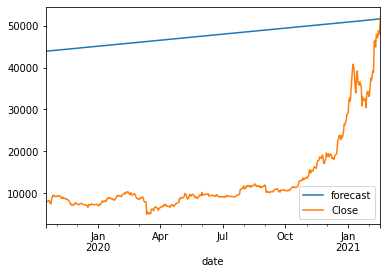

In [74]:
arima.plot_predict(10, 500, dynamic=True);

# Prophet Basic

In [41]:
# Most of this run is taken from Olavo's first prophet model

Prophet is a procedure for forecasting time series data based on an **additive model** where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. ... Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

If the seasonality and residual components are independent of the trend, then you have an **additive series**. If the seasonality and residual components are in fact dependent, meaning they fluctuate on trend, then you have a **multiplicative series**.

!!! Prophet is addtive by *default* but it can be changed through parameter
> seasonality_mode: 'additive' (default) or 'multiplicative'.

The Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:
>- y(t)= g(t) + s(t) + h(t) + εt
>- g(t): piecewise linear or logistic growth curve for modeling non-periodic changes in time series
>- s(t): periodic changes (e.g. weekly/yearly seasonality)
>- h(t): effects of holidays (user provided) with irregular schedules
>- εt: error term accounts for any unusual changes not accommodated by the model

Using time as a regressor, **Prophet is trying to fit several linear and non linear functions of time as components.** Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique . Prophet is framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

In [30]:
df_basic = df.drop(columns='Fear&Greed')

In [31]:
df_basic = df_basic.rename(columns={"date": "ds","price":"y"})

In [32]:
df_basic['ds'] = pd.to_datetime(df_basic['ds'])
df_basic.dtypes

ds    datetime64[ns]
y            float64
dtype: object

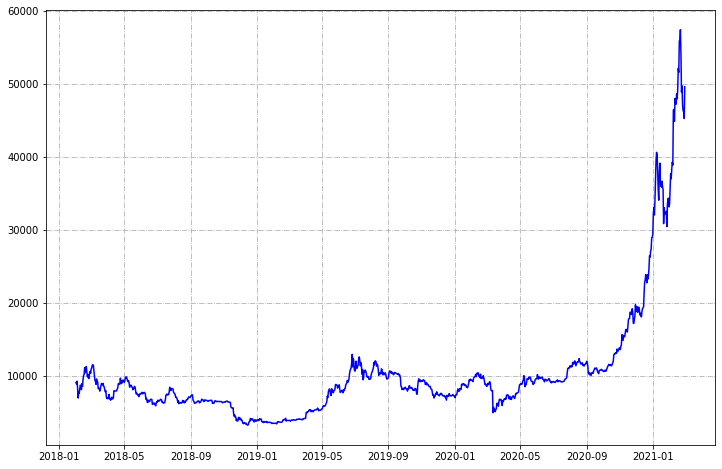

In [33]:
plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

plt.plot(df_basic['ds'], df_basic['y'], 'b')
plt.show()

In [137]:
# train/test split.
train = df_basic.iloc[:1066]
test = df_basic.iloc[1066:]

In [73]:
df_basic.shape

(1122, 2)

## Basic model, no input paramters

Prophet’s API is very similar to sklearn’s API; first we create a model, then .fit(our data), and, finally, make a forecast. The input to the fit method is a DataFrame with two columns:
>- ds (‘datestamp’) must be of type date or datetime
>- y is a measured (numeric) value to be predicted

In [35]:
# This is the basic prophet model, consider using some more inputs
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
horizon = 30
future = model.make_future_dataframe(horizon) #build a dataframe on which to fit daily predictions 
forecast = model.predict(future)

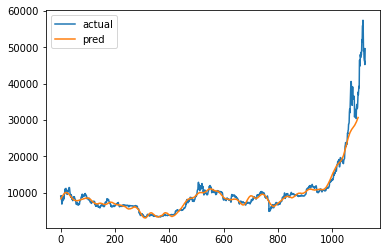

In [38]:
plt.plot(df_basic["y"], label="actual")
plt.plot(forecast["yhat"], label="pred")
plt.legend()

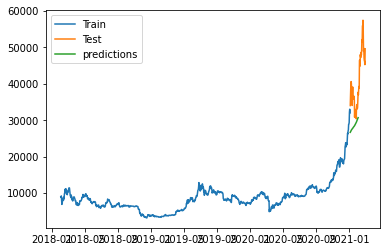

In [39]:
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")

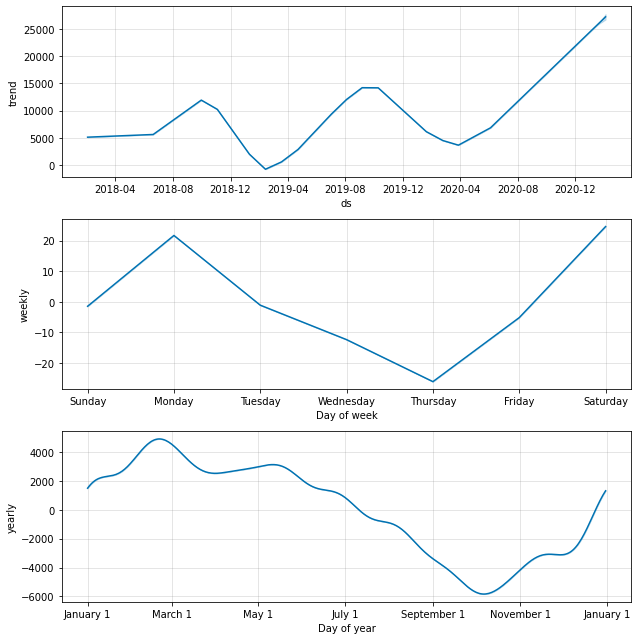

In [40]:
model.plot_components(forecast);

In [42]:
cv_results = cross_validation(model=model, initial=f'{70 * 5} days', horizon='30 days',
                              period='35 days')

INFO:fbprophet:Making 20 forecasts with cutoffs between 2019-02-09 00:00:00 and 2020-12-05 00:00:00


  0%|          | 0/20 [00:00<?, ?it/s]

In [47]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-02-10,4013.076085,3559.058590,4497.233398,3681.0517,2019-02-09
1,2019-02-11,4144.257207,3659.069033,4645.256847,3621.0283,2019-02-09
2,2019-02-12,4289.635810,3803.775543,4777.064016,3622.7133,2019-02-09
3,2019-02-13,4348.422777,3841.752238,4848.354239,3605.3133,2019-02-09
4,2019-02-14,4518.006407,4039.275014,4968.089793,3592.9100,2019-02-09


In [44]:
performance_metrics(cv_results)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,1.481632e+06,1217.223165,950.268183,0.105322,0.089207,0.583333
1,4 days,1.543027e+06,1242.186562,1002.663531,0.112795,0.089583,0.500000
2,5 days,1.692824e+06,1301.085528,1058.187379,0.121114,0.093265,0.466667
3,6 days,1.887478e+06,1373.855196,1117.647851,0.129680,0.105512,0.466667
4,7 days,2.030495e+06,1424.954270,1149.800619,0.136431,0.110697,0.483333
5,8 days,2.321086e+06,1523.511009,1225.991968,0.146304,0.116225,0.450000
6,9 days,2.617708e+06,1617.933145,1311.565593,0.155906,0.130579,0.383333
7,10 days,2.928514e+06,1711.290274,1413.815594,0.166041,0.131852,0.333333
8,11 days,3.541103e+06,1881.781977,1552.014672,0.179274,0.152807,0.250000
9,12 days,4.904744e+06,2214.665691,1733.173942,0.202585,0.155691,0.216667


## Lets try to play with the prophet parameters (the one above is using basic prophet model)

In [67]:
# Optional smaller time-period to zone-in on variations 
train_short = df_basic.iloc[:600]
test_short = df_basic.iloc[600:800]

In [122]:
# interval_width=0.95’, this sets the uncertainty interval to produce a confidence interval around the forecast.
# weekly_seasonality=True to try and see if trading follows weekly variations
# changepoint_prior_scale=2 to make the model more flexible to fit the data points
# add_seasonality to add monthly seasonality (check)
model2 = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
# model2.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

In [99]:
model2.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [100]:
horizon_short = 3
future2 = model2.make_future_dataframe(horizon_short)
forecast2 = model2.predict(future)

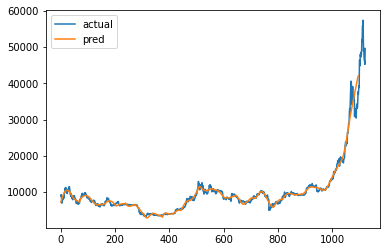

In [101]:
plt.plot(df_basic["y"], label="actual")
plt.plot(forecast2["yhat"], label="pred")
plt.legend()

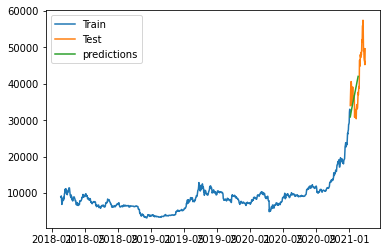

In [71]:
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast2[-horizon_short:]['ds'], forecast2[-horizon_short:]['yhat'], label="predictions")
plt.legend(loc="best")

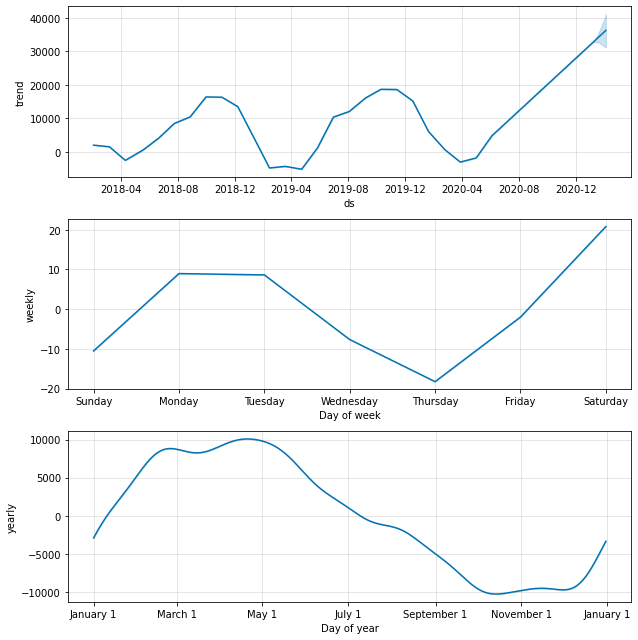

In [72]:
model2.plot_components(forecast2);

In [104]:
cv_results = cross_validation(model=model2, initial=f'{70*10} days', horizon='10 days')

INFO:fbprophet:Making 72 forecasts with cutoffs between 2020-01-05 00:00:00 and 2020-12-25 00:00:00


  0%|          | 0/72 [00:00<?, ?it/s]

In [105]:
performance_metrics(cv_results)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,5.049232e+05,710.579503,523.672806,0.049958,0.038210,0.833333
1,2 days,6.813801e+05,825.457535,608.927631,0.059826,0.043636,0.791667
2,3 days,7.791168e+05,882.675917,647.300684,0.061662,0.048686,0.736111
3,4 days,9.364177e+05,967.686757,693.515388,0.066386,0.052004,0.805556
4,5 days,1.221768e+06,1105.335955,809.872173,0.075729,0.058478,0.638889
5,6 days,1.332206e+06,1154.212347,859.540303,0.083089,0.062223,0.680556
6,7 days,1.537180e+06,1239.830694,941.192856,0.091539,0.069109,0.638889
7,8 days,1.972719e+06,1404.535010,1017.025131,0.094034,0.076204,0.666667
8,9 days,2.294872e+06,1514.883659,1084.004411,0.097690,0.070138,0.638889
9,10 days,2.550887e+06,1597.149657,1188.173437,0.105683,0.078058,0.555556


In [107]:
cv_results2 = cross_validation(model=model2, initial=f'{70 * 5} days', horizon='30 days')

INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-01-30 00:00:00 and 2020-12-05 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

In [108]:
performance_metrics(cv_results2)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,8.250200e+05,908.306112,678.991245,0.082880,0.065094,0.702899
1,4 days,9.667630e+05,983.241074,763.044683,0.094431,0.070808,0.659420
2,5 days,1.131872e+06,1063.894538,840.924102,0.102931,0.077652,0.608696
3,6 days,1.335575e+06,1155.670847,910.875079,0.112386,0.081281,0.601449
4,7 days,1.621988e+06,1273.572961,992.321908,0.122266,0.082908,0.594203
5,8 days,1.893455e+06,1376.028876,1050.203631,0.130108,0.081907,0.608696
6,9 days,2.174154e+06,1474.501323,1101.648127,0.135892,0.084241,0.623188
7,10 days,2.503869e+06,1582.361851,1166.093690,0.144425,0.085793,0.601449
8,11 days,2.910372e+06,1705.981298,1231.911083,0.153297,0.086095,0.608696
9,12 days,3.625615e+06,1904.104712,1357.992833,0.170030,0.099124,0.586957


In [109]:
model3 = Prophet(interval_width=0.95, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=2)
model3.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

In [110]:
model3.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [111]:
horizon_long = 55
future3 = model3.make_future_dataframe(horizon_long)
forecast3 = model3.predict(future3)

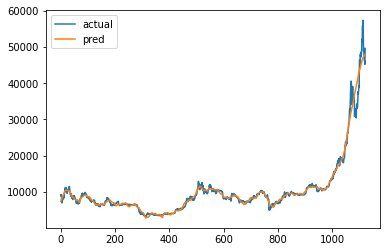

In [112]:
plt.plot(df_basic["y"], label="actual")
plt.plot(forecast["yhat"], label="pred")
plt.legend()

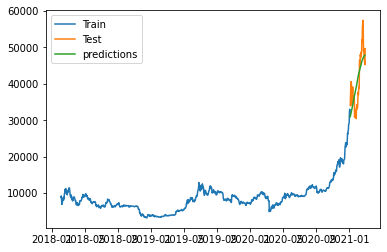

In [113]:
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast3[-horizon_long:]['ds'], forecast3[-horizon_long:]['yhat'], label="predictions")
plt.legend(loc="best")

In [114]:
cv_results = cross_validation(model=model3, initial=f'{70 * 5} days', horizon='30 days')

INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-01-30 00:00:00 and 2020-12-05 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

In [115]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-31,3839.214844,3288.911769,4455.513656,3441.9850,2019-01-30
1,2019-02-01,4082.300937,3486.656824,4698.027253,3468.2517,2019-01-30
2,2019-02-02,4355.298640,3729.697132,4978.089849,3466.2175,2019-01-30
3,2019-02-03,4577.105231,3999.089434,5199.762235,3443.1667,2019-01-30
4,2019-02-04,4748.187895,4114.332925,5337.926440,3451.1150,2019-01-30


In [116]:
performance_metrics(cv_results)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,8.432070e+05,918.263043,691.030036,0.085106,0.060679,0.652174
1,4 days,9.949063e+05,997.449885,783.926300,0.097852,0.069191,0.594203
2,5 days,1.179787e+06,1086.180136,874.280795,0.108199,0.078759,0.550725
3,6 days,1.387171e+06,1177.782426,948.044680,0.118465,0.087077,0.528986
4,7 days,1.699918e+06,1303.808946,1032.027020,0.129326,0.090409,0.514493
5,8 days,1.994404e+06,1412.233682,1089.385658,0.137590,0.090623,0.536232
6,9 days,2.310265e+06,1519.955755,1141.792628,0.144188,0.090272,0.557971
7,10 days,2.653281e+06,1628.889612,1219.971198,0.155147,0.089866,0.565217
8,11 days,3.064313e+06,1750.517834,1288.433906,0.164721,0.096221,0.594203
9,12 days,3.755377e+06,1937.879505,1417.063622,0.181517,0.110343,0.579710


## BEST model

**Hyperparameter tuning**

In [133]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1, 2, 5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10],
    'interval_width' : [0.8,0.9,0.95],
    'weekly_seasonality' : [True]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params to train data
    df_cv = cross_validation(m, initial='700 days', horizon='7 days', period = '70', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KeyboardInterrupt: 

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

**Cross-validation of prophet:** 
We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). Period = making predictions every X days. By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

In [ ]:
best_model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)

best_model.fit(train)
horizon = 7
future = best_model.make_future_dataframe(horizon)
forecast = best_model.predict(future)

In [ ]:
# plot forecasts
best_model.plot(forecast, xlabel='Date', ylabel='Price ($)')
plt.title('Bitcoin Price ($BTC)')
# display graph
plt.show()

- black dots represent actual measurements
- blue line displays Prophet’s forecast
- light blue window indicates uncertainty intervals

Prophet’s uncertainty intervals are not expected to hold exact coverage. The intervals are, “however, a useful indication of the level of uncertainty, and especially an indicator of overfitting.”

In [ ]:
# tell us more about the forecast
best_model.plot_components(forecast);

This gives insight into saying that it is 

In [ ]:
cv_results = cross_validation(model=model4, initial='700 days', horizon='7 days', period = '70', parallel="processes")

Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. 
Dots show the absolute percent error for each prediction in df_cv. 
The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. 

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [120]:
# Is it predicting on the prediction? Seems so

# Prophet with Fear & Greed

In [136]:
# train/test split with F&G
train_fg = df.iloc[:1066]
test_fg = df.iloc[1066:]

In [134]:
model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)

In [138]:
# Add regressor for F&G
model.add_regressor('FG_score')

In [139]:
model.fit(train_fg)
horizon = 7
future = model.make_future_dataframe(horizon)
future['FG_score'] = df['Fear&Greed']
forecast = model.predict(future)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.